In [1]:
library(limma)
library(edgeR)
library(tidyverse)
library(biomaRt)
library(plotly)
library(RColorBrewer)
library(GSVA)
library(reactome.db)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching core tidyverse packages ────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ──────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘plotly’


The following object is masked from ‘package:biomaRt’:

    select


The following object is masked from ‘package:ggplot2’:

    last_plot


The following object is masked from ‘package:stats’:

    filter


The following object is masked from ‘package:graphics’:

    layout


Loadi

In [2]:
projdir <- '/mnt/c/Users/benjy/Dropbox (University of Michigan)/ENGIN-Lab Notes/Lab Notes/Lab Notes Benjamin/GraceCaiSamples/8680-PD'

In [3]:
rsem <- read_tsv(file.path(projdir, 'RNAseq_analysis_8680-PD', 'counts', 'gene_expected_count.annot.txt'))

Rows: 62714 Columns: 10
── Column specification ──────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (4): gene_id, entrezgene_id, external_gene_name, description
dbl (6): 8680-PD-1, 8680-PD-2, 8680-PD-3, 8680-PD-4, 8680-PD-5, 8680-PD-6

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [4]:
head(rsem)

gene_id,entrezgene_id,external_gene_name,description,8680-PD-1,8680-PD-2,8680-PD-3,8680-PD-4,8680-PD-5,8680-PD-6
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000000003,7105,TSPAN6,tetraspanin 6 [Source:HGNC Symbol;Acc:HGNC:11858],1332,1675,1309,1684,1248,1900
ENSG00000000005,64102,TNMD,tenomodulin [Source:HGNC Symbol;Acc:HGNC:17757],0,0,0,0,0,0
ENSG00000000419,8813,DPM1,"dolichyl-phosphate mannosyltransferase subunit 1, catalytic [Source:HGNC Symbol;Acc:HGNC:3005]",1280,1504,1530,1850,1678,2067
ENSG00000000457,57147,SCYL3,SCY1 like pseudokinase 3 [Source:HGNC Symbol;Acc:HGNC:19285],321,351,306,330,286,393
ENSG00000000460,55732,C1orf112,chromosome 1 open reading frame 112 [Source:HGNC Symbol;Acc:HGNC:25565],767,885,903,815,692,1074
ENSG00000000938,2268,FGR,"FGR proto-oncogene, Src family tyrosine kinase [Source:HGNC Symbol;Acc:HGNC:3697]",8,8,11,9,10,18


# Prepare metadata

In [5]:
md <- read_csv(file.path(projdir, 'DemuxStats_8680-PD.csv'))

Rows: 6 Columns: 8
── Column specification ──────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (4): Project, Sample_ID, Description, Barcode
dbl (4): # Reads, % Reads, % Perfect Index Reads, % One Mismatch Index Reads

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [6]:
md <- md %>%
    mutate(samplename = str_split_i(Sample_ID, '_', i=1)) %>%
    as.data.frame() %>%
    column_to_rownames('samplename')
md$psi <- factor(paste('psi', rep(c(0,2,4), each=2), sep='.'))
md$treatment <- factor(rep(c('off','on'), times=3))
md$group <- factor(paste(md$psi, md$treatment, sep='.'))
md

,Project,Sample_ID,Description,Barcode,# Reads,% Reads,% Perfect Index Reads,% One Mismatch Index Reads,psi,treatment,group
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>
8680-PD-1,8680-PD,8680-PD-1_TTCCAAGC-TCAACGGT,0 psi-,TTCCAAGC-TCAACGGT,28884512,0.225,100,0,psi.0,off,psi.0.off
8680-PD-2,8680-PD,8680-PD-2_CTATTCAT-GACTAGTT,0 psi+,CTATTCAT-GACTAGTT,37384606,0.292,100,0,psi.0,on,psi.0.on
8680-PD-3,8680-PD,8680-PD-3_AAGCAATA-CGTTACTC,2 psi-,AAGCAATA-CGTTACTC,32594369,0.255,100,0,psi.2,off,psi.2.off
8680-PD-4,8680-PD,8680-PD-4_GTTCTACG-GCAACTAG,2 psi+,GTTCTACG-GCAACTAG,33851556,0.262,100,0,psi.2,on,psi.2.on
8680-PD-5,8680-PD,8680-PD-5_AGAATCTC-ATCTGACC,4 psi-,AGAATCTC-ATCTGACC,34730815,0.272,100,0,psi.4,off,psi.4.off
8680-PD-6,8680-PD,8680-PD-6_CGGTCCGT-CGTCTATT,4 psi+,CGGTCCGT-CGTCTATT,41371896,0.322,100,0,psi.4,on,psi.4.on


In [7]:
levels(md$group)

[1] "psi.0.off" "psi.0.on"  "psi.2.off" "psi.2.on"  "psi.4.off" "psi.4.on"

# Prepare limma object

In [8]:
gene_data <- as.data.frame(rsem[,1:4])
rownames(gene_data) <- gene_data$gene_id

In [9]:
count_data <- as.data.frame(rsem[,5:10])
rownames(count_data) <- gene_data$gene_id

In [15]:
y <- DGEList(
    counts = count_data,
    genes = gene_data,
    samples = md
)

In [14]:
design <- model.matrix(~0+group, data=md)

In [16]:
y <- calcNormFactors(y)
lcpm <- cpm(y, log=TRUE, prior.count=3)

keep <- filterByExpr(y, design)
y <- y[keep,,keep.lib.sizes=FALSE]
y <- calcNormFactors(y)
lcpm_filt <- cpm(y, log=TRUE, prior.count=3)

In [305]:
saveRDS(y, file.path(projdir, 'analyses', 'DGEList.RDS'))

In [307]:
write.csv(lcpm_filt, file.path(projdir, 'analyses', 'lcpm_filt.csv'), quote=FALSE, row.names=TRUE)

# QC

## Library sizes

In [328]:
png(file.path(projdir, 'analyses', 'Plots', 'RNAseqlibsize.png'))
barplot(y$samples$lib.size * 1e-6, names.arg = rownames(y$samples), las=2)
dev.off()

png 
  2

## Plot count distributions

In [18]:
cols.sample <- brewer.pal(nlevels(y$samples$group), 'Paired')
names(cols.sample) <- levels(y$samples$group)

In [19]:
L <- mean(y$samples$lib.size) * 1e-6
M <- median(y$samples$lib.size) * 1e-6

In [20]:
lcpm_cutoff <- log(10/M + 3/L)

In [335]:
png(file.path(projdir, 'analyses', 'Plots', 'count_distributions.png'), width=8, height=5, units='in', res=300)
par(mfrow=c(1,2))

plot(density(lcpm[,1]), col = cols.sample[1], main = 'Before filtering', ylim=c(0,2.5), xlab='log(cpm)')
for(i in 2:ncol(lcpm)) {
    lines(density(lcpm[,i]), col = cols.sample[y$samples$group[i]])
}
abline(v=lcpm_cutoff, lty=2)
legend('topright', legend=levels(y$samples$group), lty=1, col=cols.sample)

plot(density(lcpm_filt[,1]), col = cols.sample[1], main = 'After filtering', ylim=c(0,0.2), xlab='log(cpm)')
for(i in 2:ncol(lcpm_filt)) {
    lines(density(lcpm_filt[,i]), col = cols.sample[y$samples$group[i]])
}
abline(v=lcpm_cutoff, lty=2)
dev.off()

png 
  2

## Correlation

In [298]:
anno_col <- y$samples[,c('psi','treatment')]
anno_colors <- list(psi = c(psi.0 = 'firebrick', psi.2 = 'forestgreen', psi.4 = 'dodgerblue'), 
                    treatment = c(on = 'black', off = 'white'))

In [336]:
pheatmap::pheatmap(
    cor(lcpm_filt, method='spearman'),
    annotation_col = anno_col, 
    annotation_colors = anno_colors,
    scale='row',
    show_colnames = FALSE,
    color = colorRampPalette(rev(brewer.pal(11, 'RdBu')))(200),
    filename = file.path(projdir, 'analyses', 'Plots', 'spearman_hmp.png')
)

In [327]:
pheatmap::pheatmap(
    cor(lcpm_filt, method='pearson'),
    annotation_col = anno_col, 
    annotation_colors = anno_colors,
    scale='row',
    show_colnames = FALSE,
    color = colorRampPalette(rev(brewer.pal(11, 'RdBu')))(200),
    filename = file.path(projdir, 'analyses', 'Plots', 'pearson_hmp.png')
)

## Top 500 Var heatmap

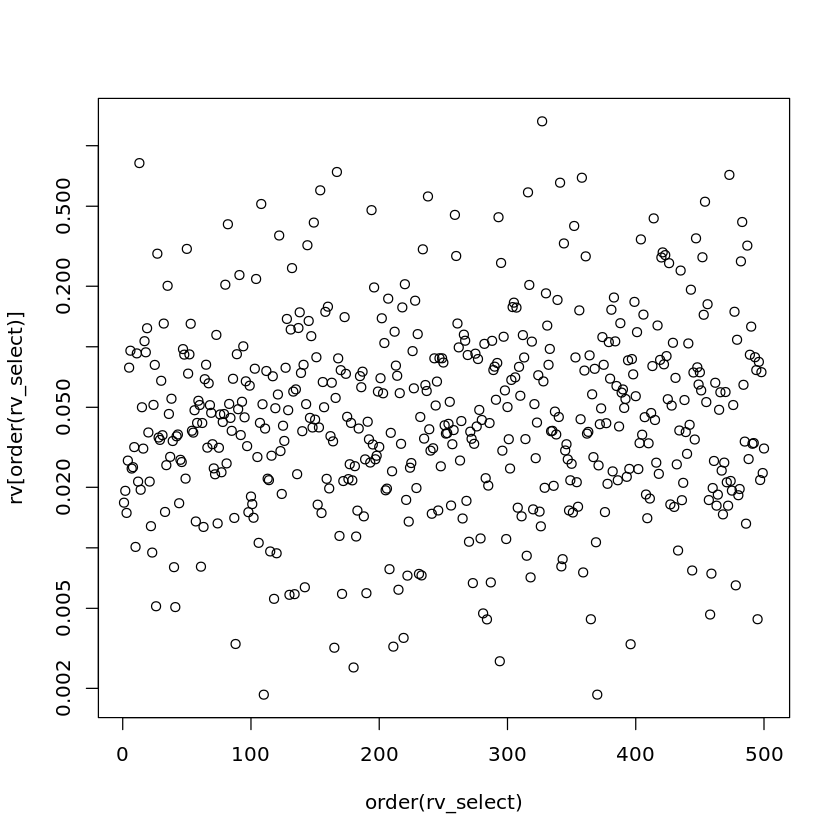

In [94]:
rv <- matrixStats::rowVars(lcpm_filt)
rv_select <- order(rv, decreasing=TRUE)[1:500]

plot(order(rv_select), rv[order(rv_select)], log='y')

In [337]:
pheatmap::pheatmap(
    lcpm_filt[rv_select,],
    scale = 'row', 
    show_rownames = FALSE,
    annotation_col = anno_col,
    annotation_colors = anno_colors,
    color = colorRampPalette(rev(brewer.pal(11, 'RdBu')))(200),
    filename = file.path(projdir, 'analyses', 'Plots', 'top500_var_hmp.png')
)

# PCA

In [29]:
pca <- prcomp(t(lcpm_filt[rv_select,]))
exp_var <- pca$sdev^2 / sum(pca$sdev^2)

In [30]:
pairs_pch <- c(on=16, off=17)

In [340]:
png(file.path(projdir, 'analyses', 'Plots', 'pca.png'), res=300, units='in', width=6, height=6)
pairs(
    pca$x[,1:5], 
    upper.panel=NULL, 
    pch = pairs_pch[y$samples$treatment],
    col = anno_colors$psi[y$samples$psi],
    cex = 2,
    label = sprintf('PC%i\n%0.2f%%', 1:5, 100*exp_var[1:5]))
par(xpd=TRUE)
legend('topright', 
       legend = c(names(anno_colors$psi), names(pairs_pch)),
       pt.cex = 2,
       pch = c(rep(15, length(anno_colors$psi)), pairs_pch), 
       col = c(anno_colors$psi, 'black', 'black'))
dev.off()

png 
  2

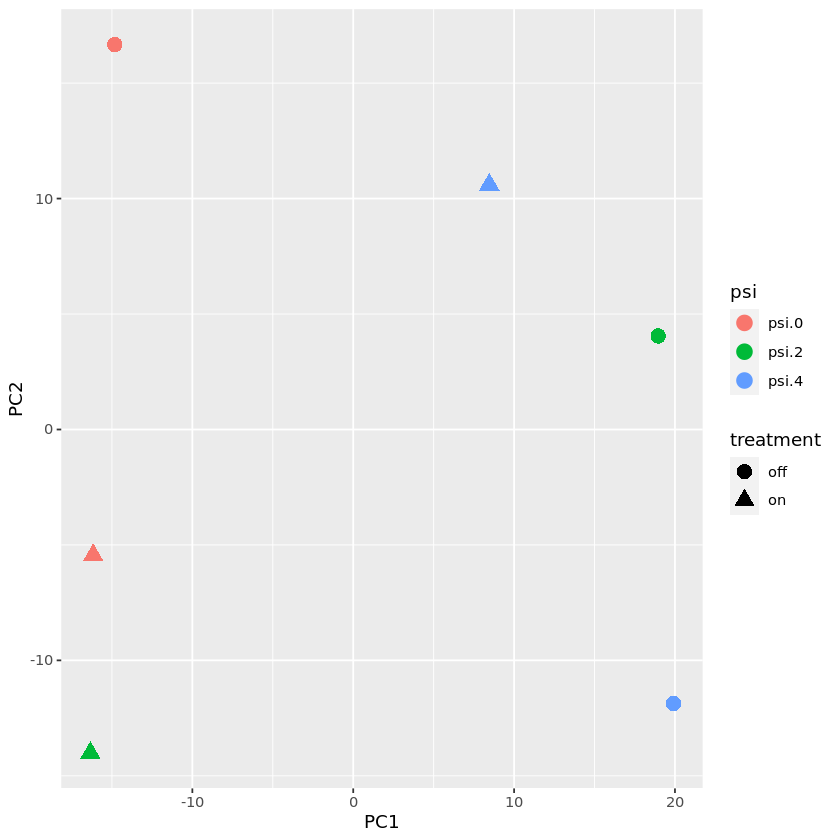

In [32]:
cbind(pca$x, y$samples) %>% ggplot(aes(PC1, PC2)) + geom_point(aes(color=psi, shape=treatment), size=4)

## PCA loadings

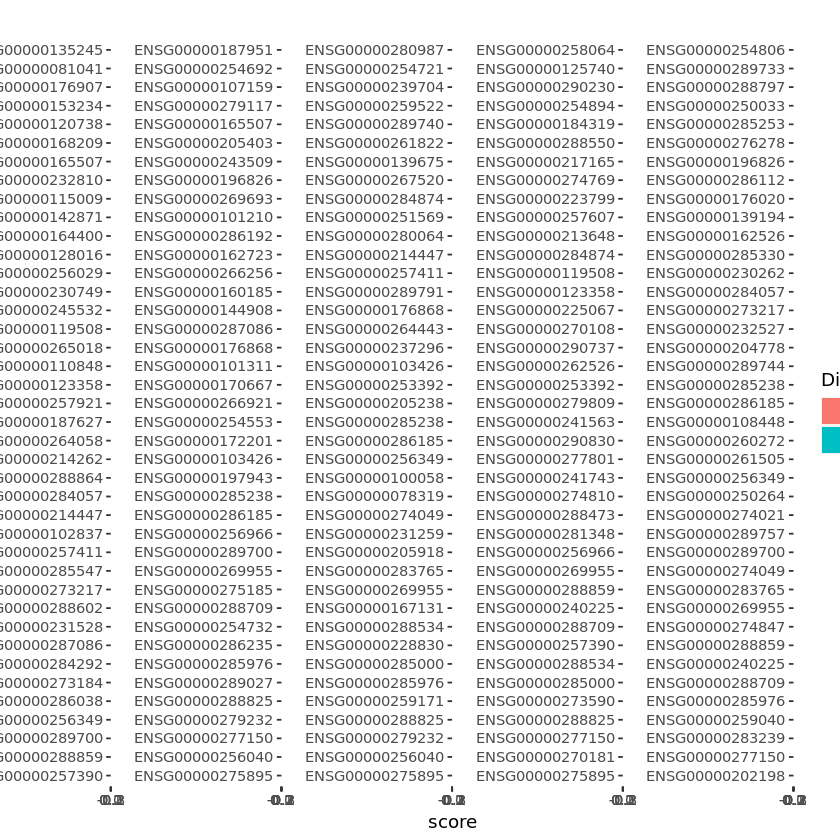

In [341]:
pca$rotation[,1:5] %>%
    as.data.frame() %>%
    rownames_to_column('gene') %>%
    pivot_longer(!gene, names_to='PC', values_to='score') %>%
    left_join(rsem[,c('gene_id','external_gene_name')], by=c('gene'='gene_id')) %>%
    mutate(Direction = as.factor(sign(score))) %>%
    group_by(PC, Direction) %>%
    dplyr::slice_max(abs(score), n=20) %>%
    ungroup() %>%
    arrange(score) %>%
    mutate(gene = factor(gene, levels=unique(gene))) %>%
    mutate(external_gene_name = factor(external_gene_name, levels=unique(external_gene_name))) %>%
    ggplot(aes(score, gene)) +
        facet_wrap(~PC, ncol=5, scales='free_y') +
        geom_col(aes(fill=Direction))
ggsave(file.path(projdir, 'analyses', 'Plots', 'pca_loadings_ens.png'), width=20, height=8)

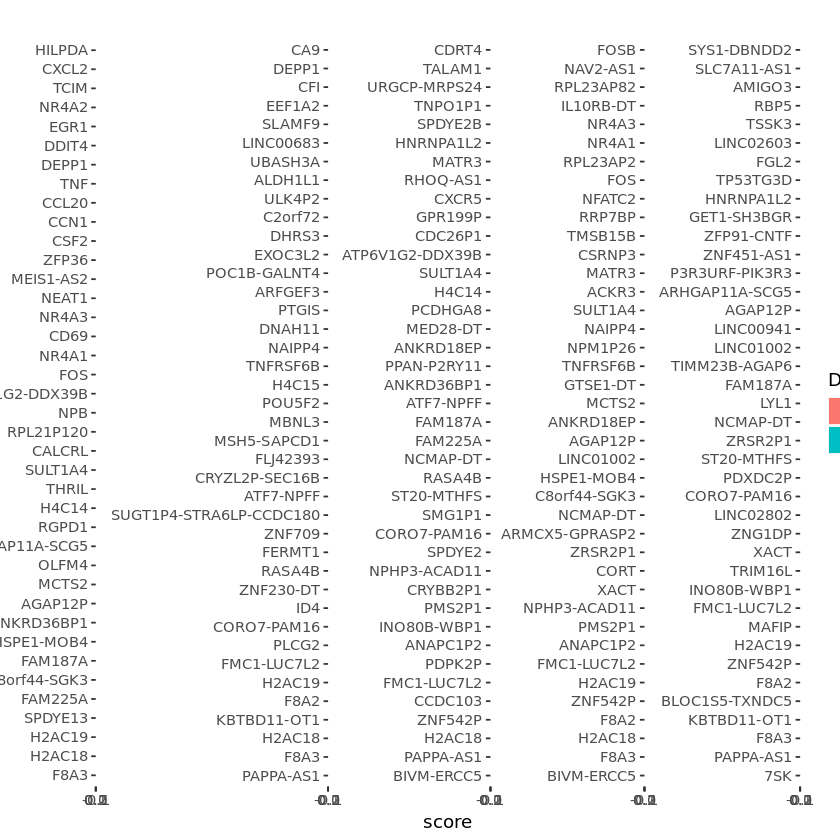

In [343]:
pca$rotation[,1:5] %>%
    as.data.frame() %>%
    rownames_to_column('gene') %>%
    pivot_longer(!gene, names_to='PC', values_to='score') %>%
    left_join(rsem[,c('gene_id','external_gene_name')], by=c('gene'='gene_id')) %>%
    dplyr::filter(external_gene_name != '.') %>%
    mutate(Direction = as.factor(sign(score))) %>%
    group_by(PC, Direction) %>%
    dplyr::slice_max(abs(score), n=20) %>%
    ungroup() %>%
    arrange(score) %>%
    mutate(external_gene_name = factor(external_gene_name, levels=unique(external_gene_name))) %>%
    ggplot(aes(score, external_gene_name)) +
        facet_wrap(~PC, ncol=5, scales='free_y') +
        geom_col(aes(fill=Direction))
ggsave(file.path(projdir, 'analyses', 'Plots', 'pca_loadings_sym.png'), width=20, height=8)

# SVA

In [35]:
library(sva)

Loading required package: mgcv

Loading required package: nlme


Attaching package: ‘nlme’


The following object is masked from ‘package:IRanges’:

    collapse


The following object is masked from ‘package:dplyr’:

    collapse


This is mgcv 1.9-0. For overview type 'help("mgcv-package")'.

Loading required package: genefilter


Attaching package: ‘genefilter’


The following object is masked from ‘package:readr’:

    spec


Loading required package: BiocParallel



In [40]:
mod0 <- model.matrix(~1, data=y$samples)
mod1 <- model.matrix(~0+group, data=y$samples)

In [41]:
num.sv(lcpm_filt, mod1, method='be')

ERROR: Error in dstat0[, i]: subscript out of bounds


In [38]:
sva.obj <- sva(lcpm_filt, mod1, mod0, n.sv=1)

Number of significant surrogate variables is:  1 
Iteration (out of 5 ):1  2  3  4  5  

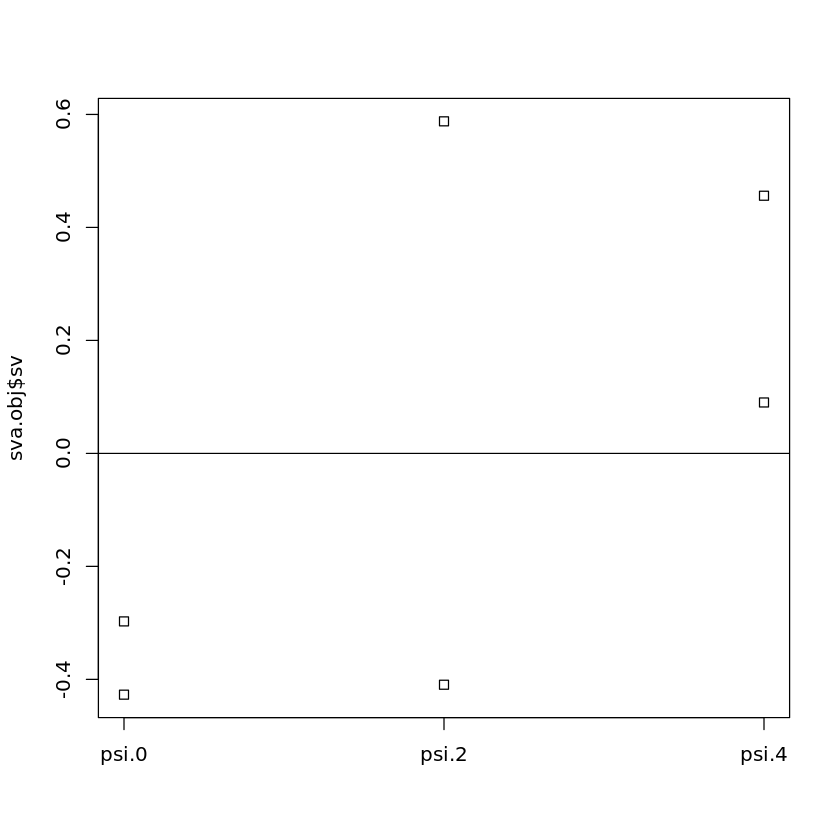

In [39]:
stripchart(sva.obj$sv ~ y$samples$psi, vertical=TRUE)
abline(h=0)

In [166]:
sva_lcpm_filt <- removeBatchEffect(lcpm_filt, covariates = sva.obj$sv[,1], design = mod1)

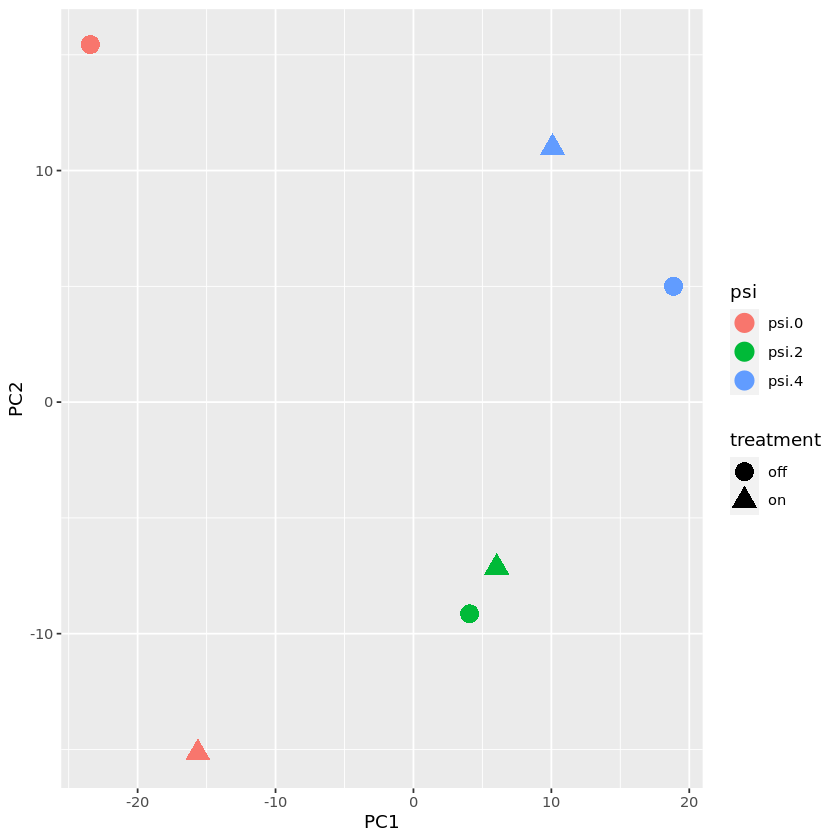

In [167]:
sva_rv <- rowVars(sva_lcpm_filt)
sva_rv_select <- order(sva_rv, decreasing=TRUE)[1:500]
sva_pca <- prcomp(t(sva_lcpm_filt[sva_rv_select,]))
cbind(sva_pca$x, y$samples) %>%
    ggplot(aes(PC1, PC2)) + geom_point(aes(color=psi, shape=treatment), size=5)

In [129]:
pairs_pch <- c(on=16, off=17)

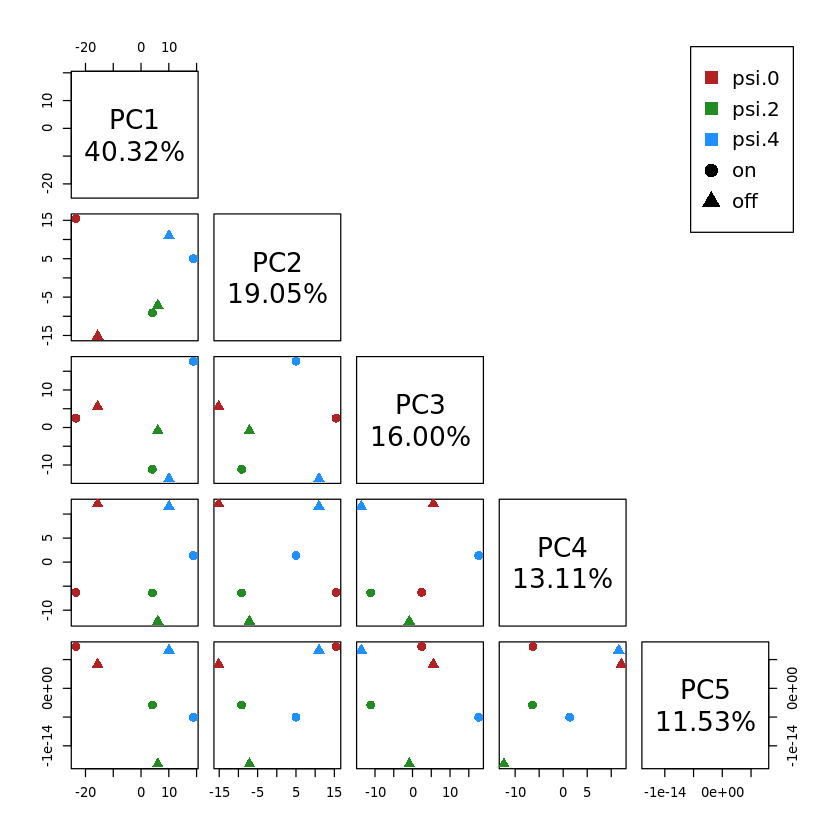

In [211]:
pairs(
    sva_pca$x[,1:5], 
    upper.panel=NULL, 
    pch = pairs_pch[y$samples$treatment],
    col = anno_colors$psi[y$samples$psi],
    cex = 1.5,
    label = sprintf('PC%i\n%0.2f%%', 1:5, 100*exp_var[1:5]))
par(xpd=TRUE)
legend('topright', 
       pt.cex = 1.5,
       legend = c(names(anno_colors$psi), names(pairs_pch)),
       pch = c(rep(15, length(anno_colors$psi)), pairs_pch), 
       col = c(anno_colors$psi, 'black', 'black'))

In [34]:
sva_pca$rotation %>%
    as.data.frame() %>%
    rownames_to_column('gene') %>%
    pivot_longer(!gene, names_to='PC', values_to='score') %>%
    left_join(rsem[,c('gene_id','external_gene_name')], by=c('gene'='gene_id')) %>%
    dplyr::filter(external_gene_name != '.') %>%
    group_by(PC, sign(score)) %>%
    dplyr::slice_max(n=20, order_by=abs(score)) %>%
    ungroup() %>%
    arrange(score) %>%
    mutate(gene = factor(external_gene_name, levels=unique(external_gene_name))) %>%
    ggplot(aes(score, gene)) + facet_wrap(~PC, scales='free_y') + geom_col(aes(fill=as.factor(sign(score))))

ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'x' in selecting a method for function 'as.data.frame': object 'sva_pca' not found


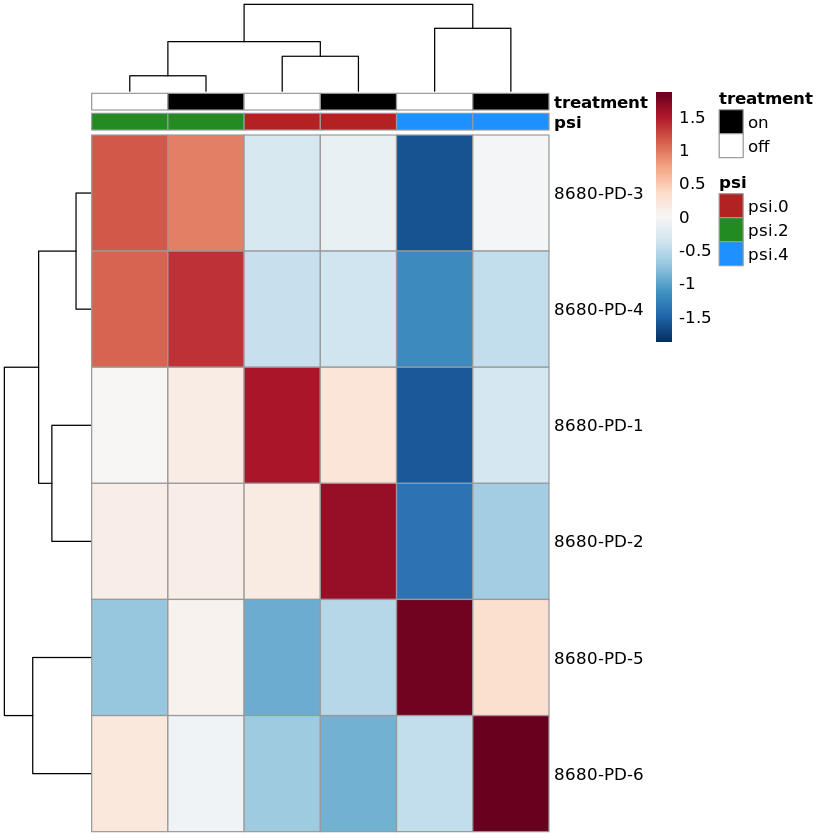

In [182]:
pheatmap::pheatmap(
    cor(sva_lcpm_filt, method='spearman'),
    annotation_col = anno_col, 
    annotation_colors = anno_colors,
    scale='row',
    show_colnames = FALSE,
    color = colorRampPalette(rev(brewer.pal(11, 'RdBu')))(200)
)

In [172]:
sva_design <- cbind(mod1, sva.obj$sv)
colnames(sva_design)[4] <- 'sv1'

In [173]:
sva_design

,psipsi.0,psipsi.2,psipsi.4,sv1
8680-PD-1,1,0,0,-0.3049069
8680-PD-2,1,0,0,-0.4353351
8680-PD-3,0,1,0,0.5796717
8680-PD-4,0,1,0,-0.4057106
8680-PD-5,0,0,1,0.4513037
8680-PD-6,0,0,1,0.1149771


# Model fitting

In [320]:
v <- voom(y, sva_design, plot = TRUE)

ERROR: Error in voom(y, sva_design, plot = TRUE): object 'sva_design' not found


In [176]:
colnames(sva_design)

[1] "psipsi.0" "psipsi.2" "psipsi.4" "sv1"

In [177]:
cont.matrix <- makeContrasts(
    psi_2vs0 = psipsi.2 - psipsi.0, 
    psi_4vs0 = psipsi.4 - psipsi.0,
    psi_4vs2 = psipsi.4 - psipsi.2,
    levels = sva_design
)

fit <- lmFit(sva_lcpm_filt, sva_design)
fit <- contrasts.fit(fit, cont.matrix)
efit <- eBayes(fit, trend=TRUE, robust=TRUE)

fit2 <- lmFit(v, sva_design)
fit2 <- contrasts.fit(fit2, cont.matrix)
efit2 <- eBayes(fit2, robust=TRUE)

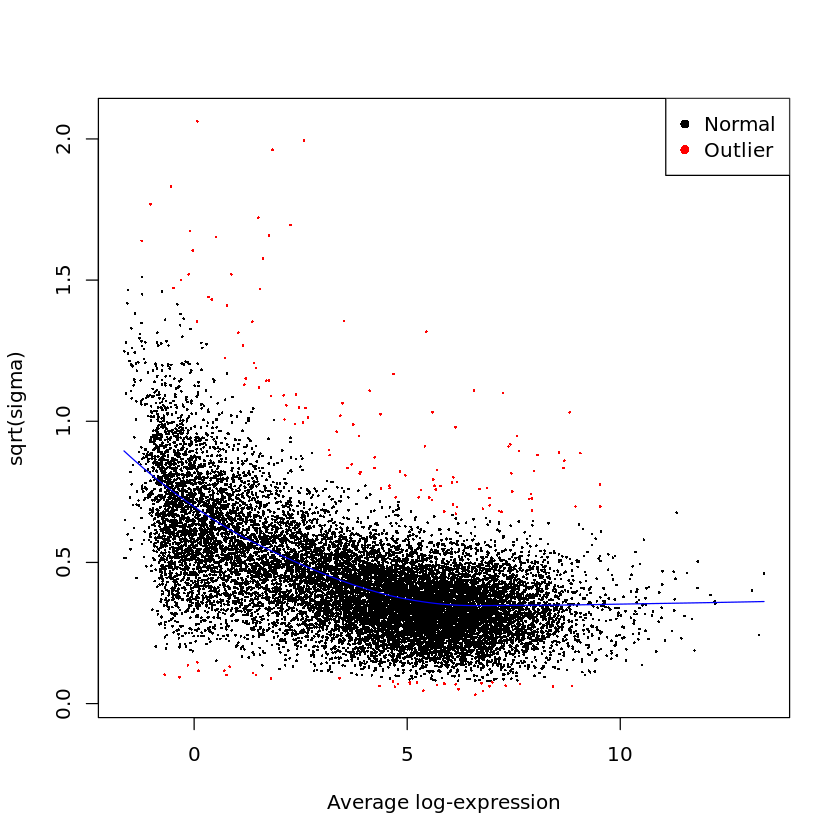

In [178]:
plotSA(efit)

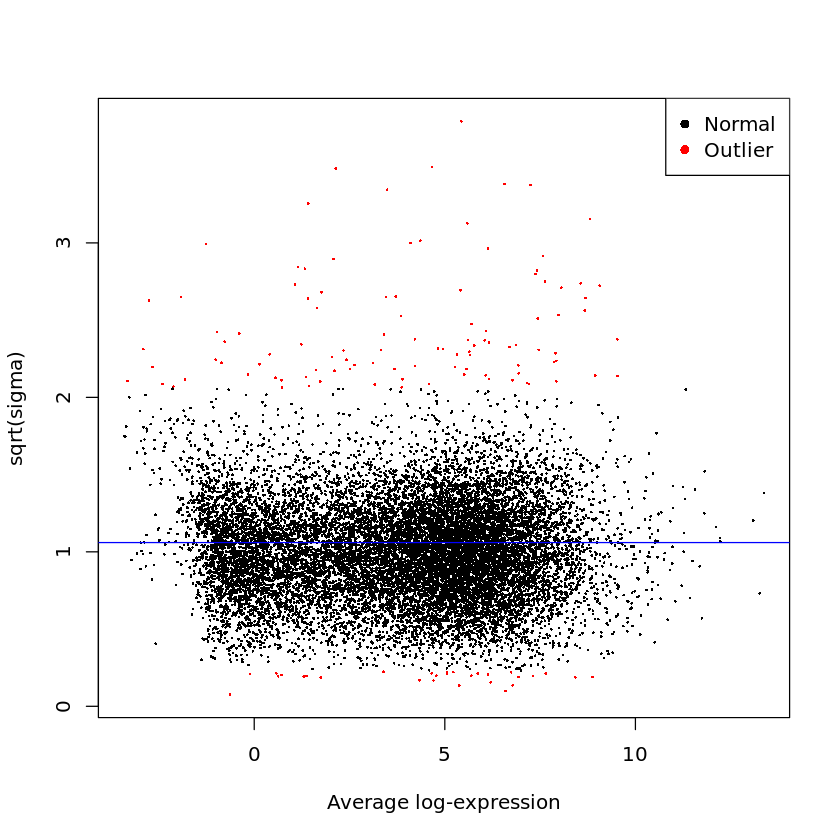

In [179]:
plotSA(efit2)

In [180]:
edt <- decideTests(efit)
edt2 <- decideTests(efit2)

In [181]:
summary(edt); summary(edt2)

       psi_2vs0 psi_4vs0 psi_4vs2
Down          0        1        0
NotSig    15619    15610    15619
Up            0        8        0

       psi_2vs0 psi_4vs0 psi_4vs2
Down          0        2        0
NotSig    15619    15609    15619
Up            0        8        0

# GSVA

In [180]:
reactome_ID2name <- as.list(reactomePATHID2NAME)

In [79]:
reactome_path2ID <- as.list(reactomePATHID2EXTID)
reactome_path2ID <- reactome_path2ID[grepl('HSA',names(reactome_path2ID),fixed=TRUE)]

In [82]:
lcpm_entrez_idx <- match(rownames(lcpm_filt), y$genes$gene_id)
lcpm_entrez_idx <- lcpm_entrez_idx[y$genes$entrezgene_id[lcpm_entrez_idx] != '.']
lcpm_entrez_idx <- lcpm_entrez_idx[y$genes$entrezgene_id[lcpm_entrez_idx] != '']
lcpm_entrez_idx <- lcpm_entrez_idx[!grepl(',', y$genes$entrezgene_id[lcpm_entrez_idx])]
lcpm_entrez_idx <- lcpm_entrez_idx[!is.na(y$genes$entrezgene_id[lcpm_entrez_idx])]
lcpm_entrez_idx <- lcpm_entrez_idx[!duplicated(y$genes$entrezgene_id[lcpm_entrez_idx])]
lcpm_filt_entrez <- lcpm_filt[lcpm_entrez_idx,]
rownames(lcpm_filt_entrez) <- y$genes$entrezgene_id[lcpm_entrez_idx]
#sva_lcpm_filt_entrez <- sva_lcpm_filt[lcpm_entrez_idx,]
#rownames(sva_lcpm_filt_entrez) <- y$genes$entrezgene_id[lcpm_entrez_idx]

In [83]:
gsva_reactome <- gsva(lcpm_filt_entrez, reactome_path2ID, min.sz=10, max.sz=500)

Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE.”


Estimating GSVA scores for 1393 gene sets.
Estimating ECDFs with Gaussian kernels
  |======================================================================| 100%



In [344]:
gsva_reactome_hmp <- pheatmap::pheatmap(
    gsva_reactome, 
    annotation_col=anno_col, annotation_colors=anno_colors,
    show_rownames=FALSE,
    color = colorRampPalette(rev(brewer.pal(11,'RdBu')))(200),
    filename = file.path(projdir, 'analyses', 'Plots', 'gsva_hmp.png'))

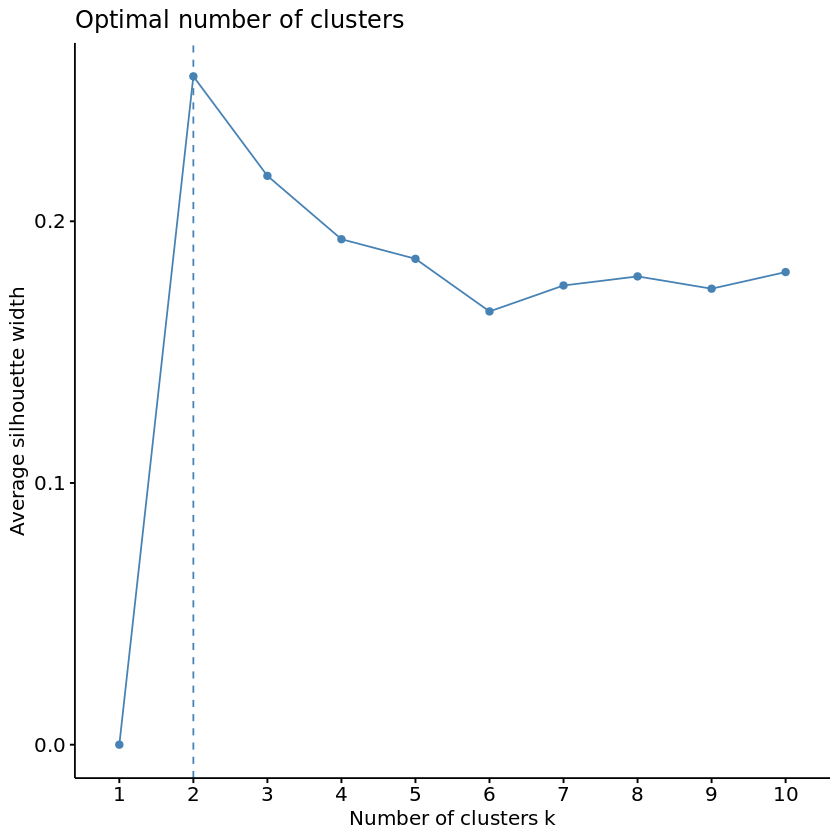

In [107]:
factoextra::fviz_nbclust(gsva_reactome, kmeans, method = "silhouette")

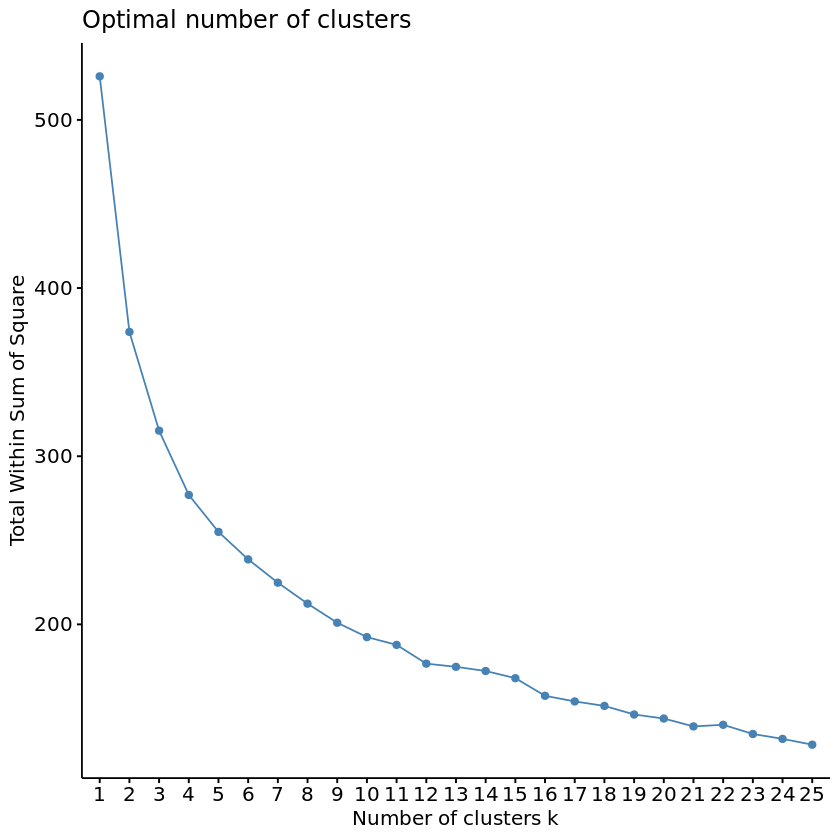

In [113]:
factoextra::fviz_nbclust(gsva_reactome, kmeans, method = "wss", k.max = 25)

In [346]:
library(DEGreport)

In [353]:
head(y$samples)

,group,lib.size,norm.factors,Project,Sample_ID,Description,Barcode,X..Reads,X..Reads.1,X..Perfect.Index.Reads,X..One.Mismatch.Index.Reads,psi,treatment
,<fct>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>
8680-PD-1,psi.0.off,14642979,1.0064562,8680-PD,8680-PD-1_TTCCAAGC-TCAACGGT,0 psi-,TTCCAAGC-TCAACGGT,28884512,0.225,100,0,psi.0,off
8680-PD-2,psi.0.on,18714012,1.0211331,8680-PD,8680-PD-2_CTATTCAT-GACTAGTT,0 psi+,CTATTCAT-GACTAGTT,37384606,0.292,100,0,psi.0,on
8680-PD-3,psi.2.off,16507264,0.9862419,8680-PD,8680-PD-3_AAGCAATA-CGTTACTC,2 psi-,AAGCAATA-CGTTACTC,32594369,0.255,100,0,psi.2,off
8680-PD-4,psi.2.on,18609034,0.9801119,8680-PD,8680-PD-4_GTTCTACG-GCAACTAG,2 psi+,GTTCTACG-GCAACTAG,33851556,0.262,100,0,psi.2,on
8680-PD-5,psi.4.off,16602615,1.0266844,8680-PD,8680-PD-5_AGAATCTC-ATCTGACC,4 psi-,AGAATCTC-ATCTGACC,34730815,0.272,100,0,psi.4,off
8680-PD-6,psi.4.on,21454887,0.9804527,8680-PD,8680-PD-6_CGGTCCGT-CGTCTATT,4 psi+,CGGTCCGT-CGTCTATT,41371896,0.322,100,0,psi.4,on


Working with 1393 genes.

Working with 1224 genes after filtering: minc > 1

Joining with `by = join_by(merge)`
Joining with `by = join_by(merge)`
Warning message:
“Computation failed in `stat_smooth()`
Caused by error in `poly()`:
! 'degree' must be less than number of unique points”
Warning message:
“Computation failed in `stat_smooth()`
Caused by error in `poly()`:
! 'degree' must be less than number of unique points”
Warning message:
“Computation failed in `stat_smooth()`
Caused by error in `poly()`:
! 'degree' must be less than number of unique points”
Warning message:
“Computation failed in `stat_smooth()`
Caused by error in `poly()`:
! 'degree' must be less than number of unique points”
Warning message:
“Computation failed in `stat_smooth()`
Caused by error in `poly()`:
! 'degree' must be less than number of unique points”
Warning message:
“Computation failed in `stat_smooth()`
Caused by error in `poly()`:
! 'degree' must be less than number of unique points”
Warning message:
“C

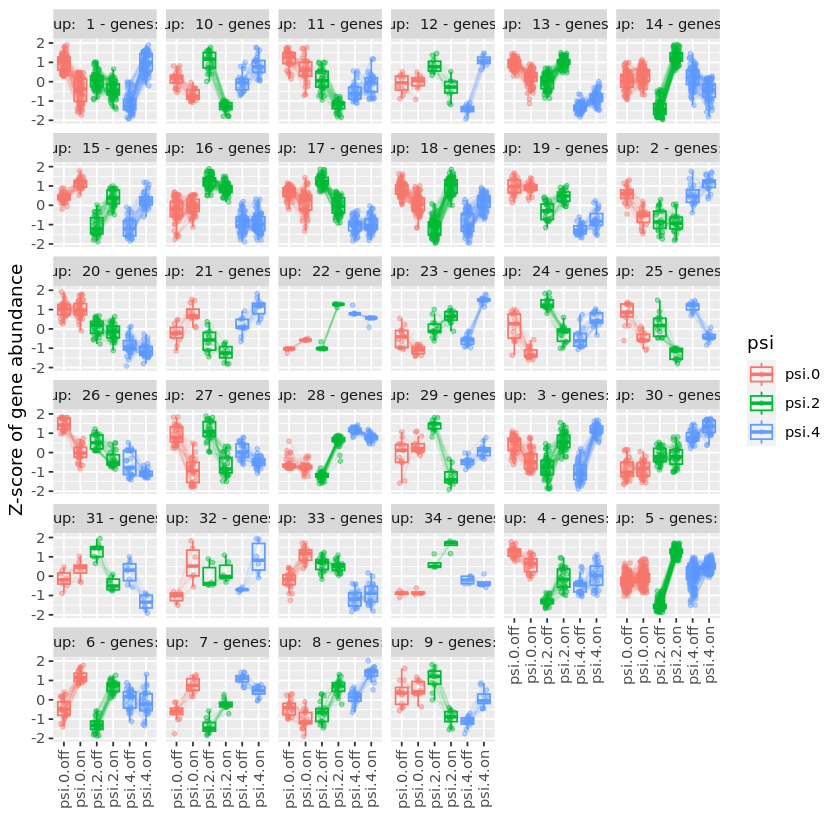

In [374]:
gsva_reactome_clusters <- degPatterns(gsva_reactome, y$samples, minc = 1, time = 'group', col = 'psi', reduce = TRUE)

Warning message:
“Computation failed in `stat_smooth()`
Caused by error in `poly()`:
! 'degree' must be less than number of unique points”
Warning message:
“Computation failed in `stat_smooth()`
Caused by error in `poly()`:
! 'degree' must be less than number of unique points”
Warning message:
“Computation failed in `stat_smooth()`
Caused by error in `poly()`:
! 'degree' must be less than number of unique points”
Warning message:
“Computation failed in `stat_smooth()`
Caused by error in `poly()`:
! 'degree' must be less than number of unique points”
Warning message:
“Computation failed in `stat_smooth()`
Caused by error in `poly()`:
! 'degree' must be less than number of unique points”
Warning message:
“Computation failed in `stat_smooth()`
Caused by error in `poly()`:
! 'degree' must be less than number of unique points”
Warning message:
“Computation failed in `stat_smooth()`
Caused by error in `poly()`:
! 'degree' must be less than number of unique points”
Warning message:
“Computati

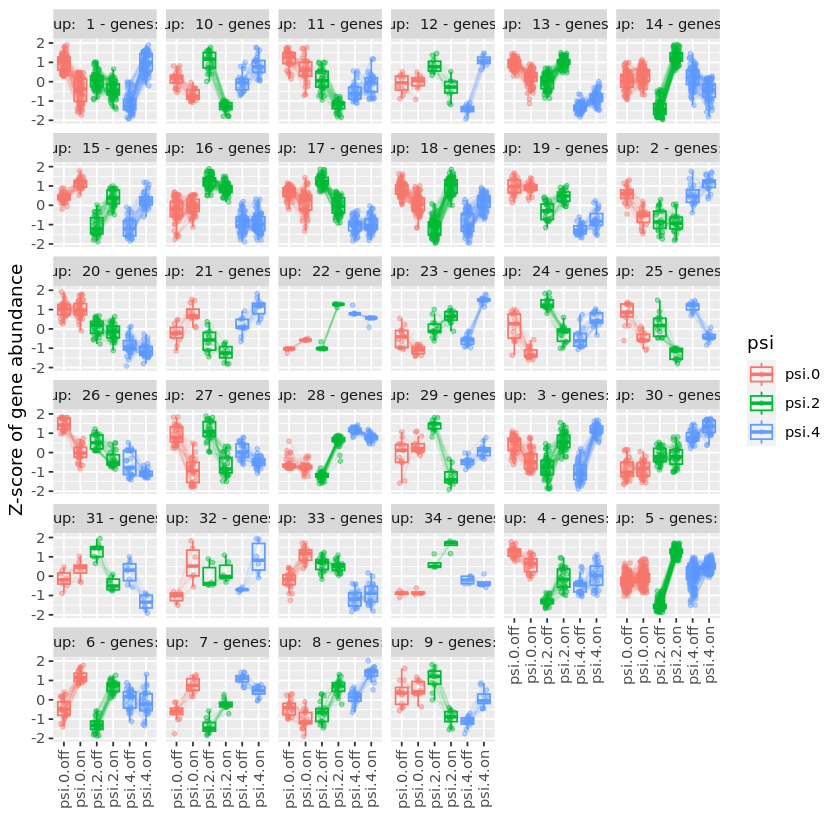

In [375]:
gsva_reactome_clusters$plot
ggsave(file.path(projdir, 'analyses', 'Plots', 'gsva_degPattern.png'), width=10, height=10)

In [379]:
gsva_reactome_clusters_df <- gsva_reactome_clusters$df
gsva_reactome_clusters_df$name <- reactome_ID2name[gsub('.','-',gsva_reactome_clusters_df$genes,fixed=TRUE)]
gsva_reactome_clusters_df$name <- gsub('Homo sapiens: ', '', gsva_reactome_clusters_df$name, fixed=TRUE)
colnames(gsva_reactome_clusters_df)[1] <- 'Reactome'
head(gsva_reactome_clusters_df)

,Reactome,cluster,name
,<chr>,<int>,<chr>
R.HSA.109582,R.HSA.109582,1,Hemostasis
R.HSA.418990,R.HSA.418990,1,Adherens junctions interactions
R.HSA.388396,R.HSA.388396,1,GPCR downstream signalling
R.HSA.397795,R.HSA.397795,1,G-protein beta:gamma signalling
R.HSA.195258,R.HSA.195258,1,RHO GTPase Effectors
R.HSA.9658195,R.HSA.9658195,1,Leishmania infection


In [380]:
write_tsv(gsva_reactome_clusters_df, file.path(projdir, 'analyses', 'gsva_reactome_clusters_df.tsv'))

In [385]:
anno_row <- data.frame(Reactome = gsub('-','.',rownames(gsva_reactome),fixed=TRUE))
anno_row <- left_join(anno_row, gsva_reactome_clusters_df, by='Reactome')
anno_row <- anno_row[gsva_reactome_hmp$tree_row$order,,drop=FALSE]
anno_row$cluster <- as.factor(anno_row$cluster)
rownames(anno_row) <- gsub('.','-',anno_row$Reactome,fixed=TRUE)
anno_row$name <- NULL
anno_row$Reactome <- NULL
head(anno_row)

,cluster
,<fct>
R-HSA-4641265,2
R-HSA-390522,2
R-HSA-1236977,30
R-HSA-380108,30
R-HSA-6783783,30
R-HSA-75205,NA


In [390]:
sample(rainbow(n=nlevels(anno_row$cluster)))

[1] "#3CFF00" "#C3FF00" "#00FFFF" "#FFB400" "#F000FF" "#FF0087" "#FFE100"
 [8] "#69FF00" "#6900FF" "#96FF00" "#FF002D" "#001EFF" "#C300FF" "#0FFF00"
[15] "#00D2FF" "#FF8700" "#FF5A00" "#00FF4B" "#FF005A" "#004BFF" "#00A5FF"
[22] "#F0FF00" "#9600FF" "#0F00FF" "#00FFA5" "#00FFD2" "#FF2D00" "#FF0000"
[29] "#00FF78" "#FF00E1" "#3C00FF" "#00FF1E" "#FF00B4" "#0078FF"

In [391]:
anno_colors$cluster <- sample(rainbow(n=nlevels(anno_row$cluster)))
names(anno_colors$cluster) <- as.character(seq_along(levels(anno_row$cluster)))

In [393]:
pheatmap::pheatmap(
    gsva_reactome, 
    #cutree_rows = 10,
    annotation_col = anno_col, 
    annotation_row = anno_row,
    annotation_colors=anno_colors,
    show_rownames=FALSE,
    color = colorRampPalette(rev(brewer.pal(11,'RdBu')))(200),
    filename = file.path(projdir, 'analyses', 'Plots', 'gsva_degPattern_hmp.png'))

Saving 6.67 x 20 in image


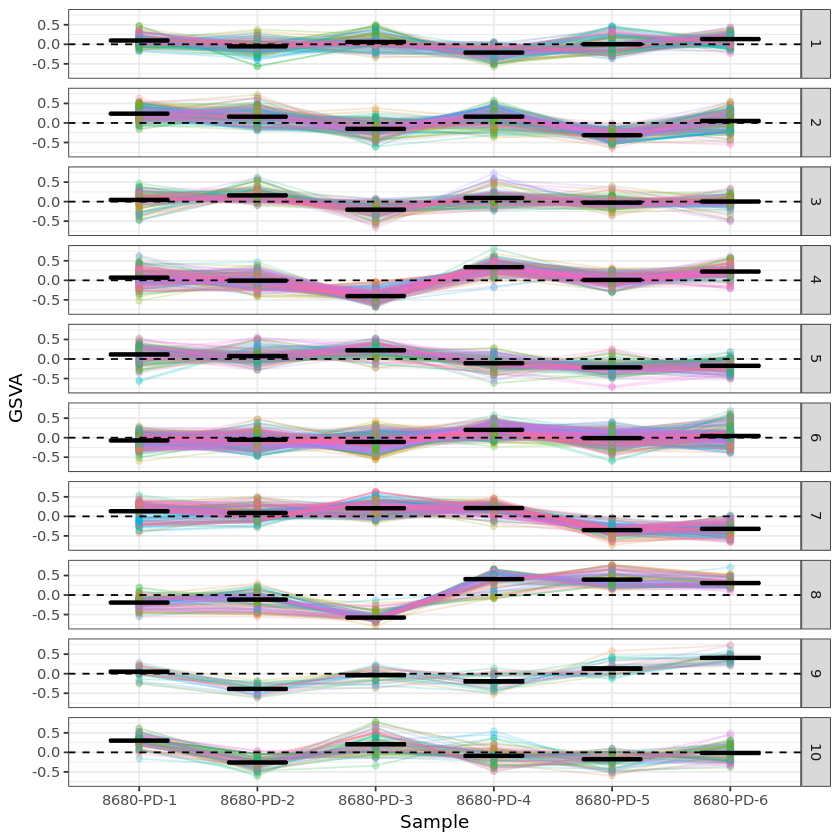

In [282]:
cbind(gsva_reactome, k10_clust) %>%
    as.data.frame() %>%
    rownames_to_column('Reactome') %>%
    pivot_longer(cols = !c(Reactome, k10_clust), names_to='Sample', values_to='GSVA') %>%
    ggplot(aes(Sample, GSVA)) +
        facet_grid(rows=vars(k10_clust)) +
        geom_line(aes(group=Reactome, color=Reactome), alpha=0.2) +
        geom_point(aes(color=Reactome), alpha=0.2) +
        stat_summary(fun.data='mean_se', geom='crossbar', width=0.5) +
        geom_hline(yintercept=0, lty=2) +
        theme_bw() +
        theme(legend.position='none')
ggsave(file.path(projdir, 'analyses', 'gsva_k10clust_trends.png'), height=20)

In [181]:
reactome_ID2name[names(k10_clust==1)]

$`R-HSA-109582`
[1] "Homo sapiens: Hemostasis"

$`R-HSA-114608`
[1] "Homo sapiens: Platelet degranulation "

$`R-HSA-6798695`
[1] "Homo sapiens: Neutrophil degranulation"

$`R-HSA-76002`
[1] "Homo sapiens: Platelet activation, signaling and aggregation"

$`R-HSA-76005`
[1] "Homo sapiens: Response to elevated platelet cytosolic Ca2+"

$`R-HSA-156580`
[1] "Homo sapiens: Phase II - Conjugation of compounds"

$`R-HSA-211859`
[1] "Homo sapiens: Biological oxidations"

$`R-HSA-9748784`
[1] "Homo sapiens: Drug ADME"

$`R-HSA-9753281`
[1] "Homo sapiens: Paracetamol ADME"

$`R-HSA-15869`
[1] "Homo sapiens: Metabolism of nucleotides"

$`R-HSA-5668914`
[1] "Homo sapiens: Diseases of metabolism"

$`R-HSA-74217`
[1] "Homo sapiens: Purine salvage"

$`R-HSA-8956321`
[1] "Homo sapiens: Nucleotide salvage"

$`R-HSA-9755088`
[1] "Homo sapiens: Ribavirin ADME"

$`R-HSA-1500931`
[1] "Homo sapiens: Cell-Cell communication"

$`R-HSA-381426`
[1] "Homo sapiens: Regulation of Insulin-like Growth Factor (IGF) transport and uptake by Insulin-like Growth Factor Binding Proteins (IGFBPs)"

$`R-HSA-418990`
[1] "Homo sapiens: Adherens junctions interactions"

$`R-HSA-421270`
[1] "Homo sapiens: Cell-cell junction organization"

$`R-HSA-446728`
[1] "Homo sapiens: Cell junction organization"

$`R-HSA-525793`
[1] "Homo sapiens: Myogenesis"

$`R-HSA-8957275`
[1] "Homo sapiens: Post-translational protein phosphorylation"

$`R-HSA-109581`
[1] "Homo sapiens: Apoptosis"

$`R-HSA-109606`
[1] "Homo sapiens: Intrinsic Pathway for Apoptosis"

$`R-HSA-111447`
[1] "Homo sapiens: Activation of BAD and translocation to mitochondria "

$`R-HSA-114452`
[1] "Homo sapiens: Activation of BH3-only proteins"

$`R-HSA-1227986`
[1] "Homo sapiens: Signaling by ERBB2"

$`R-HSA-1257604`
[1] "Homo sapiens: PIP3 activates AKT signaling"

$`R-HSA-1358803`
[1] "Homo sapiens: Downregulation of ERBB2:ERBB3 signaling"

$`R-HSA-186712`
[1] "Homo sapiens: Regulation of beta-cell development"

$`R-HSA-194138`
[1] "Homo sapiens: Signaling by VEGF"

$`R-HSA-198323`
[1] "Homo sapiens: AKT phosphorylates targets in the cytosol"

$`R-HSA-199418`
[1] "Homo sapiens: Negative regulation of the PI3K/AKT network"

$`R-HSA-2219528`
[1] "Homo sapiens: PI3K/AKT Signaling in Cancer"

$`R-HSA-3700989`
[1] "Homo sapiens: Transcriptional Regulation by TP53"

$`R-HSA-372790`
[1] "Homo sapiens: Signaling by GPCR"

$`R-HSA-388396`
[1] "Homo sapiens: GPCR downstream signalling"

$`R-HSA-388841`
[1] "Homo sapiens: Costimulation by the CD28 family"

$`R-HSA-389356`
[1] "Homo sapiens: CD28 co-stimulation"

$`R-HSA-389357`
[1] "Homo sapiens: CD28 dependent PI3K/Akt signaling"

$`R-HSA-389513`
[1] "Homo sapiens: CTLA4 inhibitory signaling"

$`R-HSA-392451`
[1] "Homo sapiens: G beta:gamma signalling through PI3Kgamma"

$`R-HSA-397795`
[1] "Homo sapiens: G-protein beta:gamma signalling"

$`R-HSA-4420097`
[1] "Homo sapiens: VEGFA-VEGFR2 Pathway"

$`R-HSA-453279`
[1] "Homo sapiens: Mitotic G1 phase and G1/S transition"

$`R-HSA-5218920`
[1] "Homo sapiens: VEGFR2 mediated vascular permeability"

$`R-HSA-5357801`
[1] "Homo sapiens: Programmed Cell Death"

$`R-HSA-5628897`
[1] "Homo sapiens: TP53 Regulates Metabolic Genes"

$`R-HSA-5633007`
[1] "Homo sapiens: Regulation of TP53 Activity"

$`R-HSA-5663202`
[1] "Homo sapiens: Diseases of signal transduction by growth factor receptors and second messengers"

$`R-HSA-5674400`
[1] "Homo sapiens: Constitutive Signaling by AKT1 E17K in Cancer"

$`R-HSA-6804757`
[1] "Homo sapiens: Regulation of TP53 Degradation"

$`R-HSA-6804758`
[1] "Homo sapiens: Regulation of TP53 Activity through Acetylation"

$`R-HSA-6804759`
[1] "Homo sapiens: Regulation of TP53 Activity through Association with Co-factors"

$`R-HSA-6806003`
[1] "Homo sapiens: Regulation of TP53 Expression and Degradation"

$`R-HSA-6807070`
[1] "Homo sapiens: PTEN Regulation"

$`R-HSA-69202`
[1] "Homo sapiens: Cyclin E associated events during G1/S transition "

$`R-HSA-69206`
[1] "Homo sapiens: G1/S Transition"

$`R-HSA-69242`
[

In [184]:
jaccard <- function(a, b) {
    intersection = length(intersect(a, b))
    union = length(a) + length(b) - intersection
    return (intersection/union)
}

In [188]:
entrez_genes <- rownames(lcpm_filt_entrez)
genes_in_reactome <- sapply(reactome_path2ID, function(i) intersect(i, entrez_genes))

In [269]:
reactome_clust_combo <- list()
reactome_clust_jaccard <- list()
for(i in unique(k10_clust)) {
    reactome_clust_combo[[i]] <- t(combn(names(k10_clust[k10_clust==i]), 2))
    reactome_clust_jaccard[[i]] <- apply(combo, 1, function(x) jaccard(genes_in_reactome[[x[1]]], genes_in_reactome[[x[2]]]))
}

In [284]:
reactome_ID2name[unique(reactome_clust_combo[[7]][,2][reactome_clust_jaccard[[7]]>0.8])]

$`R-HSA-1250347`
[1] "Homo sapiens: SHC1 events in ERBB4 signaling"

$`R-HSA-1963640`
[1] "Homo sapiens: GRB2 events in ERBB2 signaling"

$`R-HSA-1963642`
[1] "Homo sapiens: PI3K events in ERBB2 signaling"

$`R-HSA-6811558`
[1] "Homo sapiens: PI5P, PP2A and IER3 Regulate PI3K/AKT Signaling"

$`R-HSA-9664565`
[1] "Homo sapiens: Signaling by ERBB2 KD Mutants"

$`R-HSA-9013409`
[1] "Homo sapiens: RHOJ GTPase cycle"

$`R-HSA-9700206`
[1] "Homo sapiens: Signaling by ALK in cancer"

$`R-HSA-9725370`
[1] "Homo sapiens: Signaling by ALK fusions and activated point mutants"

$`R-HSA-4615885`
[1] "Homo sapiens: SUMOylation of DNA replication proteins"

$`R-HSA-9022699`
[1] "Homo sapiens: MECP2 regulates neuronal receptors and channels"

$`R-HSA-5223345`
[1] "Homo sapiens: Miscellaneous transport and binding events"

$`R-HSA-1296072`
[1] "Homo sapiens: Voltage gated Potassium channels"

$`R-HSA-8848021`
[1] "Homo sapiens: Signaling by PTK6"

$`R-HSA-9006927`
[1] "Homo sapiens: Signaling by Non-Receptor Tyrosine Kinases"

$`R-HSA-5654695`
[1] "Homo sapiens: PI-3K cascade:FGFR2"

$`R-HSA-8983432`
[1] "Homo sapiens: Interleukin-15 signaling"

$`R-HSA-5637812`
[1] "Homo sapiens: Signaling by EGFRvIII in Cancer"

$`R-HSA-9704646`
[1] "Homo sapiens: Defective HDR through Homologous Recombination Repair (HRR) due to PALB2 loss of BRCA2/RAD51/RAD51C binding function"

$`R-HSA-9709570`
[1] "Homo sapiens: Impaired BRCA2 binding to RAD51"

$`R-HSA-3232142`
[1] "Homo sapiens: SUMOylation of ubiquitinylation proteins"

$`R-HSA-204005`
[1] "Homo sapiens: COPII-mediated vesicle transport"

$`R-HSA-5654708`
[1] "Homo sapiens: Downstream signaling of activated FGFR3"

$`R-HSA-1362277`
[1] "Homo sapiens: Transcription of E2F targets under negative control by DREAM complex"

$`R-HSA-186763`
[1] "Homo sapiens: Downstream signal transduction"

$`R-HSA-512988`
[1] "Homo sapiens: Interleukin-3, Interleukin-5 and GM-CSF signaling"

$`R-HSA-8875656`
[1] "Homo sapiens: MET receptor recycling"

$`R-HSA-9006335`
[1] "Homo sapiens: Signaling by Erythropoietin"

$`R-HSA-114604`
[1] "Homo sapiens: GPVI-mediated activation cascade"

$`R-HSA-2871809`
[1] "Homo sapiens: FCERI mediated Ca+2 mobilization"

$`R-HSA-5619102`
[1] "Homo sapiens: SLC transporter disorders"

$`R-HSA-9665348`
[1] "Homo sapiens: Signaling by ERBB2 ECD mutants"

$`R-HSA-9673767`
[1] "Homo sapiens: Signaling by PDGFRA transmembrane, juxtamembrane and kinase domain mutants"

$`R-HSA-5693554`
[1] "Homo sapiens: Resolution of D-loop Structures through Synthesis-Dependent Strand Annealing (SDSA)"

$`R-HSA-5693568`
[1] "Homo sapiens: Resolution of D-loop Structures through Holliday Junction Intermediates"

$`R-HSA-168271`
[1] "Homo sapiens: Transport of Ribonucleoproteins into the Host Nucleus"

$`R-HSA-168274`
[1] "Homo sapiens: Export of Viral Ribonucleoproteins from Nucleus"

$`R-HSA-912526`
[1] "Homo sapiens: Interleukin receptor SHC signaling"

$`R-HSA-2980766`
[1] "Homo sapiens: Nuclear Envelope Breakdown"

$`R-HSA-159227`
[1] "Homo sapiens: Transport of the SLBP independent Mature mRNA"

$`R-HSA-159230`
[1] "Homo sapiens: Transport of the SLBP Dependant Mature mRNA"

$`R-HSA-159231`
[1] "Homo sapiens: Transport of Mature mRNA Derived from an Intronless Transcript"

$`R-HSA-159234`
[1] "Homo sapiens: Transport of Mature mRNAs Derived from Intronless Transcripts"

$`R-HSA-2426168`
[1] "Homo sapiens: Activation of gene expression by SREBF (SREBP)"

$`R-HSA-5620920`
[1] "Homo sapiens: Cargo trafficking to the periciliary membrane"

$`R-HSA-429914`
[1] "Homo sapiens: Deadenylation-dependent mRNA decay"

$`R-HSA-264876`
[1] "Homo sapiens: Insulin processing"

$`R-HSA-9694631`
[1] "Homo sapiens: Maturation of nucleoprotein"

$`R-HSA-432142`
[1] "Homo sapiens: Platelet sensitization by LDL"

$`R-HSA-180910`
[1] "Homo sapiens: Vpr-mediated nuclear import of PICs"

$`R-HSA-2428924`
[1] "Homo sapiens: IGF1R signaling cascade"

$`R-HSA-5654710`
[1] "Homo sapiens: PI-3K cascade:FGFR3"

$`R-HSA-9013420`
[1] "Ho